In [1]:
import pickle
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense,GRU,Dropout

Using TensorFlow backend.


In [2]:
def limit_sentences(txt_str,num_words):
    
    return ' '.join(txt_str.lower().split(' ')[:num_words]).replace('\n',' ')

In [3]:
query_response = pickle.load(open("../data/query_response_direct_one_sentence.p","rb"))

In [4]:
query_response_limited = []
for (q,r) in query_response:
    if (len(str(q).strip().split()) >= 1) and (len(str(r).strip().split()) >= 1):
        query_response_limited.append((limit_sentences(str(q),num_words = 30),limit_sentences(str(r),num_words = 15)))

In [5]:
print(len(query_response))
print(len(query_response_limited))

3999
3925


In [6]:
lines = query_response_limited

In [10]:
%%time
batch_size = 8  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 300 # Number of samples to train on.


#Vectorize the data for words
input_texts = []
target_texts = []
input_words = set()
target_words = set()


# Option 2
for seq1, seq2 in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = seq1, seq2
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '<BOS> ' + target_text + ' <EOS>' #'<BOS>' + target_text + '<EOS>'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # Only one input word
    input_text_list = input_text.split()
    if len(input_text_list) == 1:
        input_words.add(input_text_list[0])
    # Multiple input words
    else:
        for word in input_text_list:
            input_words.add(word)
                
    # For right now we are only looking at 1 target...the medication
    target_text_list = target_text.split()
    for word in target_text_list:
        target_words.add(word)

# Option 2
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
# set max input sequence (may need to pad...)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 300
Number of unique input tokens: 499
Number of unique output tokens: 894
Max sequence length for inputs: 198
Max sequence length for outputs: 155
CPU times: user 2.31 ms, sys: 126 µs, total: 2.44 ms
Wall time: 2.47 ms


In [11]:
# Option 2
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_words)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    input_text_list = input_text.split()
    if len(input_text_list) > 1:
        for t, word in enumerate(input_text_list):
            encoder_input_data[i, t, input_token_index[word]] = 1.
    else:
        encoder_input_data[i, t, input_token_index[input_text_list[0]]] = 1.
    
    target_text_list = target_text.split()
    for t, word in enumerate(target_text_list):
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.



## GRU

In [20]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, 
              return_state=True,
             dropout=.3)
encoder_outputs, state_h = encoder(encoder_inputs)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru = GRU(latent_dim, return_sequences=True)
decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 13s 50ms/step - loss: 0.3010 - val_loss: 0.2873
Epoch 2/100
270/270 [==============================] - 12s 44ms/step - loss: 0.2671 - val_loss: 0.2942
Epoch 3/100
270/270 [==============================] - 13s 49ms/step - loss: 0.2601 - val_loss: 0.3003
Epoch 4/100
270/270 [==============================] - 14s 51ms/step - loss: 0.2554 - val_loss: 0.3155
Epoch 5/100
270/270 [==============================] - 12s 45ms/step - loss: 0.2510 - val_loss: 0.3132
Epoch 6/100
270/270 [==============================] - 12s 45ms/step - loss: 0.2484 - val_loss: 0.3209
Epoch 7/100
270/270 [==============================] - 12s 45ms/step - loss: 0.2447 - val_loss: 0.3241
Epoch 8/100
270/270 [==============================] - 12s 46ms/step - loss: 0.2420 - val_loss: 0.3358
Epoch 9/100
270/270 [==============================] - 12s 45ms/step - loss: 0.2393 - val_loss: 0.3413
Epoch 10/100
270/270 [======

## LSTM

In [12]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True,dropout=.1,recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 21s 78ms/step - loss: 0.2825 - val_loss: 0.2887
Epoch 2/100
270/270 [==============================] - 20s 74ms/step - loss: 0.2629 - val_loss: 0.3000
Epoch 3/100
270/270 [==============================] - 20s 73ms/step - loss: 0.2573 - val_loss: 0.3075
Epoch 4/100
270/270 [==============================] - 20s 74ms/step - loss: 0.2530 - val_loss: 0.3184
Epoch 5/100
270/270 [==============================] - 20s 73ms/step - loss: 0.2491 - val_loss: 0.3292
Epoch 6/100
270/270 [==============================] - 20s 72ms/step - loss: 0.2460 - val_loss: 0.3388
Epoch 7/100
270/270 [==============================] - 19s 72ms/step - loss: 0.2431 - val_loss: 0.3383
Epoch 8/100
270/270 [==============================] - 20s 72ms/step - loss: 0.2406 - val_loss: 0.3502
Epoch 9/100
270/270 [==============================] - 19s 72ms/step - loss: 0.2381 - val_loss: 0.3567
Epoch 10/100
270/270 [======

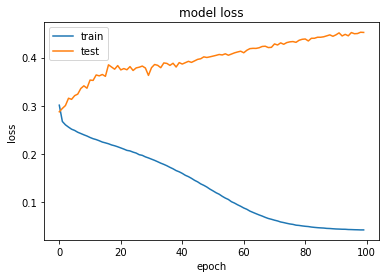

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
(i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0, target_token_index['<BOS>']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        #print('decoded_sentence internal',decoded_sentence)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '' or
           len(decoded_sentence) > max_decoder_seq_length):
            #print("sample char {}".format(sampled_char))
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence.replace('<EOS>','')

In [14]:
# Option 1
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq =decoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thing happen january    right m                
-
Input sentence: pertinent fact
Decoded sentence:  -pron- m doctor thin